In [2]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

In [3]:
import FinanceDataReader as fdr
# 삼성전자로 세팅. 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2023-07-01', '2024-12-31')
df.tail

<bound method NDFrame.tail of              Open   High    Low  Close    Volume    Change
Date                                                      
2023-07-03  72700  73200  72600  73000  10722181  0.011080
2023-07-04  73400  73600  72900  73000  10214350  0.000000
2023-07-05  73000  73300  71900  72000  12310610 -0.013699
2023-07-06  71900  72400  71500  71600  14777667 -0.005556
2023-07-07  71100  71400  69800  69900  17308877 -0.023743
...           ...    ...    ...    ...       ...       ...
2024-01-17  73100  73300  71000  71000  22683660 -0.022039
2024-01-18  71600  72000  70700  71700  17853397  0.009859
2024-01-19  73500  74700  73000  74700  23363427  0.041841
2024-01-22  75900  76000  75000  75100  19673375  0.005355
2024-01-23  75700  75800  74300  75200  14722676  0.001332

[138 rows x 6 columns]>

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

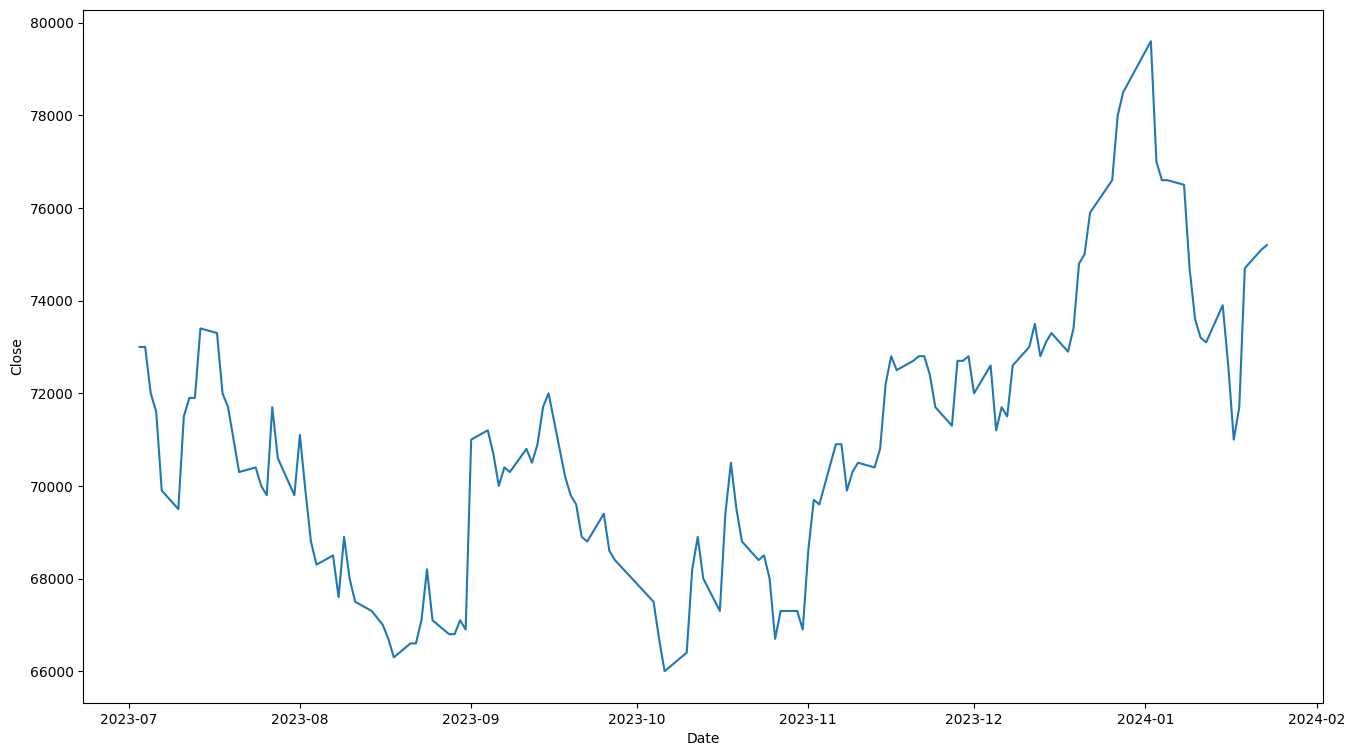

In [6]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [7]:
# 종가 제외 스케일링(y = 종가, close)이면 close를 제외해야 하는 거 아닌가?
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [8]:
# numpy 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

# 시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x)-sequence_length):
    x_seq.append(x[i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [9]:
split = 70
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

<ipython-input-8-ec9651e8db12>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


torch.Size([70, 5, 4]) torch.Size([70, 1])
torch.Size([63, 5, 4]) torch.Size([63, 1])


In [10]:
x_train_seq

tensor([[[0.5360, 0.4962, 0.5484, 0.0944],
         [0.5920, 0.5267, 0.5726, 0.0846],
         [0.5600, 0.5038, 0.4919, 0.1251],
         [0.4720, 0.4351, 0.4597, 0.1726],
         [0.4080, 0.3588, 0.3226, 0.2214]],

        [[0.5920, 0.5267, 0.5726, 0.0846],
         [0.5600, 0.5038, 0.4919, 0.1251],
         [0.4720, 0.4351, 0.4597, 0.1726],
         [0.4080, 0.3588, 0.3226, 0.2214],
         [0.3200, 0.2824, 0.2742, 0.1135]],

        [[0.5600, 0.5038, 0.4919, 0.1251],
         [0.4720, 0.4351, 0.4597, 0.1726],
         [0.4080, 0.3588, 0.3226, 0.2214],
         [0.3200, 0.2824, 0.2742, 0.1135],
         [0.3360, 0.3664, 0.3468, 0.1225]],

        ...,

        [[0.2080, 0.2290, 0.1935, 0.2600],
         [0.1600, 0.1374, 0.1532, 0.0752],
         [0.1520, 0.1374, 0.0806, 0.1306],
         [0.1360, 0.2443, 0.1290, 0.2212],
         [0.2320, 0.2901, 0.2419, 0.2057]],

        [[0.1600, 0.1374, 0.1532, 0.0752],
         [0.1520, 0.1374, 0.0806, 0.1306],
         [0.1360, 0.2443, 0.1290

In [11]:
y_train_seq

tensor([[0.2574],
        [0.4044],
        [0.4338],
        [0.4338],
        [0.5441],
        [0.5368],
        [0.4412],
        [0.4191],
        [0.3676],
        [0.3162],
        [0.3235],
        [0.2941],
        [0.2794],
        [0.4191],
        [0.3382],
        [0.2794],
        [0.3750],
        [0.2868],
        [0.2059],
        [0.1691],
        [0.1838],
        [0.1176],
        [0.2132],
        [0.1471],
        [0.1103],
        [0.0956],
        [0.0735],
        [0.0515],
        [0.0221],
        [0.0441],
        [0.0441],
        [0.0809],
        [0.1618],
        [0.0809],
        [0.0588],
        [0.0588],
        [0.0809],
        [0.0662],
        [0.3676],
        [0.3824],
        [0.3456],
        [0.2941],
        [0.3235],
        [0.3162],
        [0.3529],
        [0.3309],
        [0.3603],
        [0.4191],
        [0.4412],
        [0.3088],
        [0.2794],
        [0.2647],
        [0.2132],
        [0.2059],
        [0.2500],
        [0

In [12]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

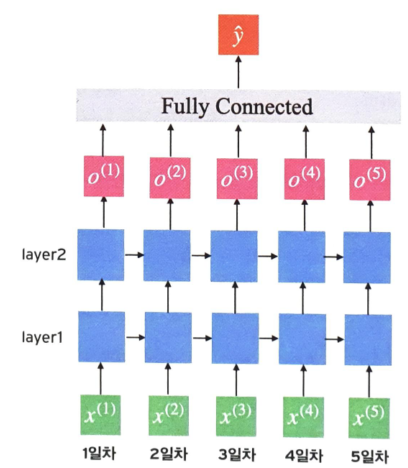

**RNN(Recurrent Neural Network)**
- 입력과 출력을 시퀀스 단위로 처리하는 순환 신경망.
- 은닉층의 노드에서 활성화 함수를 통해 나온 결과값을 **출력층 방향**으로도 보내면서 다시 은닉층 노드의 다음 계산의 입력으로 보내는 특징을 가짐.
- 다시 말하자면 은닉층의 메모리 셀은 각각의 시점(time step)에서 바로 이전 시점에서의 은닉층 출력값을 자신의 입력으로 사용하는 재귀적 활동을 하고 있음. => *현재 시점 t에서의 메모리 셀이 갖고 있는 값은 과거의 메모리 셀들의 값에 영향을 받은 것*
- nn.RNN()으로 한줄로 제공. => 메모리 셀, RNN 셀
- batch_first = True로 설정해서 입력 shape에서 batch_size가 가장 먼저 오도록 함.

many to many 전략: 1~5일차 입력을 받고 날마다 하나씩 예측하는 다대다 전략. 마지막 output 하나만 가지고 예측하지 않고, 각각의 output을 합쳐서 fc layer에 넣어서 계산.

In [13]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2) # 변수 4개
num_layers = 2 # RNN layer 개수
hidden_size = 8 # 은닉층 개수

In [14]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [15]:
model = VanillaRNN(input_size=input_size, hidden_size=hidden_size,
                   sequence_length=sequence_length, num_layers=num_layers,
                   device=device).to(device)

regression 문제이기 때문에 손실함수를 MSE로 설정.

In [16]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [17]:
# 학습
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    # RNN 학습: BPTT(back propagation through time)
    # 재귀적인 형태의 모델을 시간에 대해 펼쳐서 현재 시점의 에러를 최초 시점까지 전파에 학습하는 것
    # 전파가 길어질수록 기울기 값이 0에 가까워지는 기울기 소실 문제가 발생

    optimizer.zero_grad() #파라미터 초기화
    loss.backward() #역전파
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0500
[epoch : 10] loss: 0.0165
[epoch : 20] loss: 0.0115
[epoch : 30] loss: 0.0105
[epoch : 40] loss: 0.0092


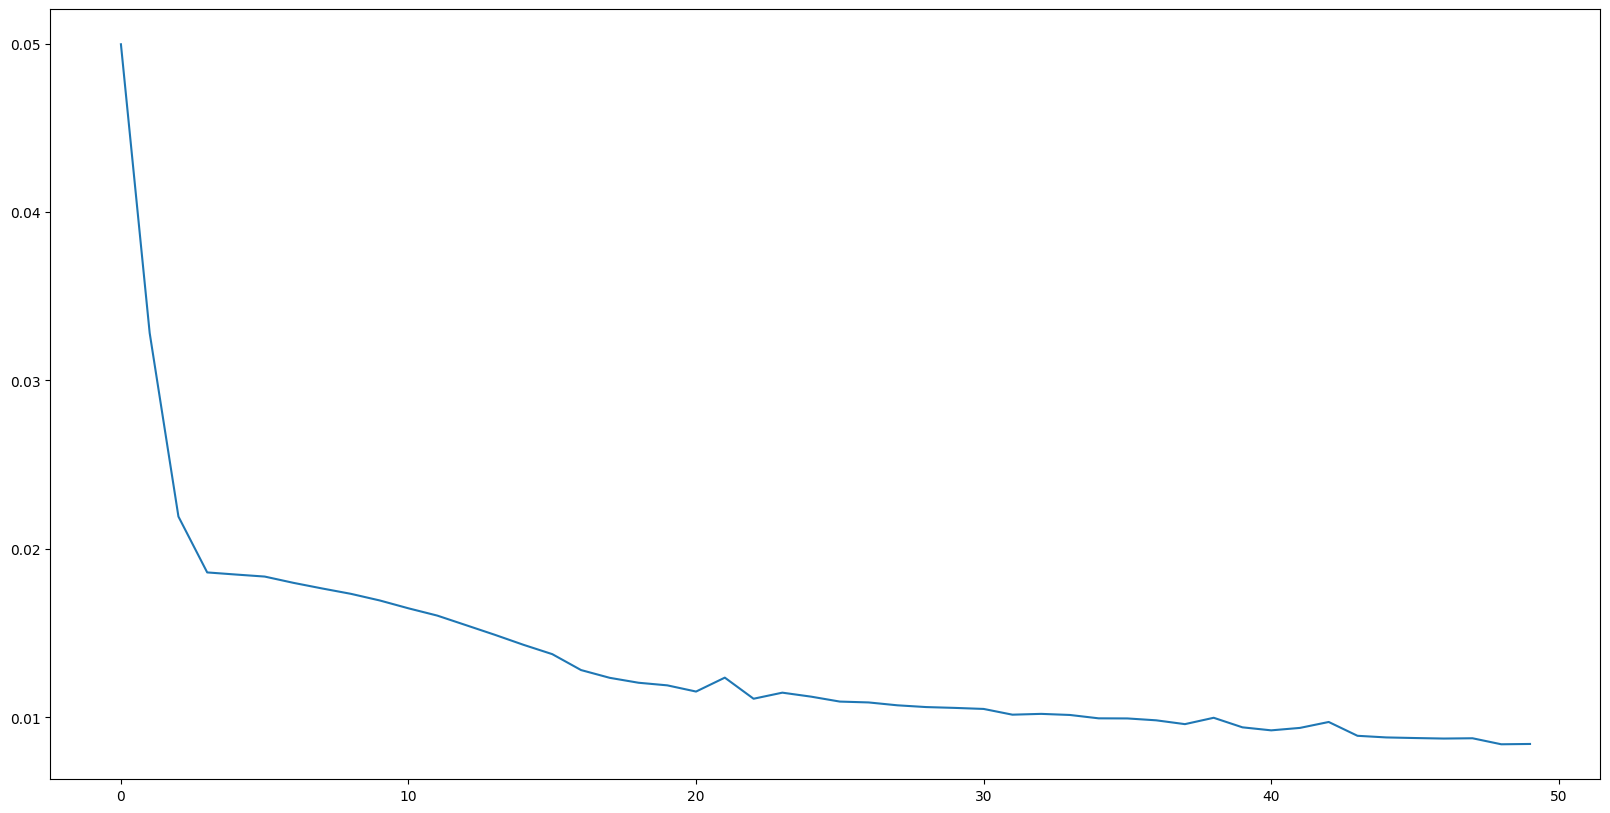

In [18]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

In [23]:
# 실제값과 예측값 비교
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

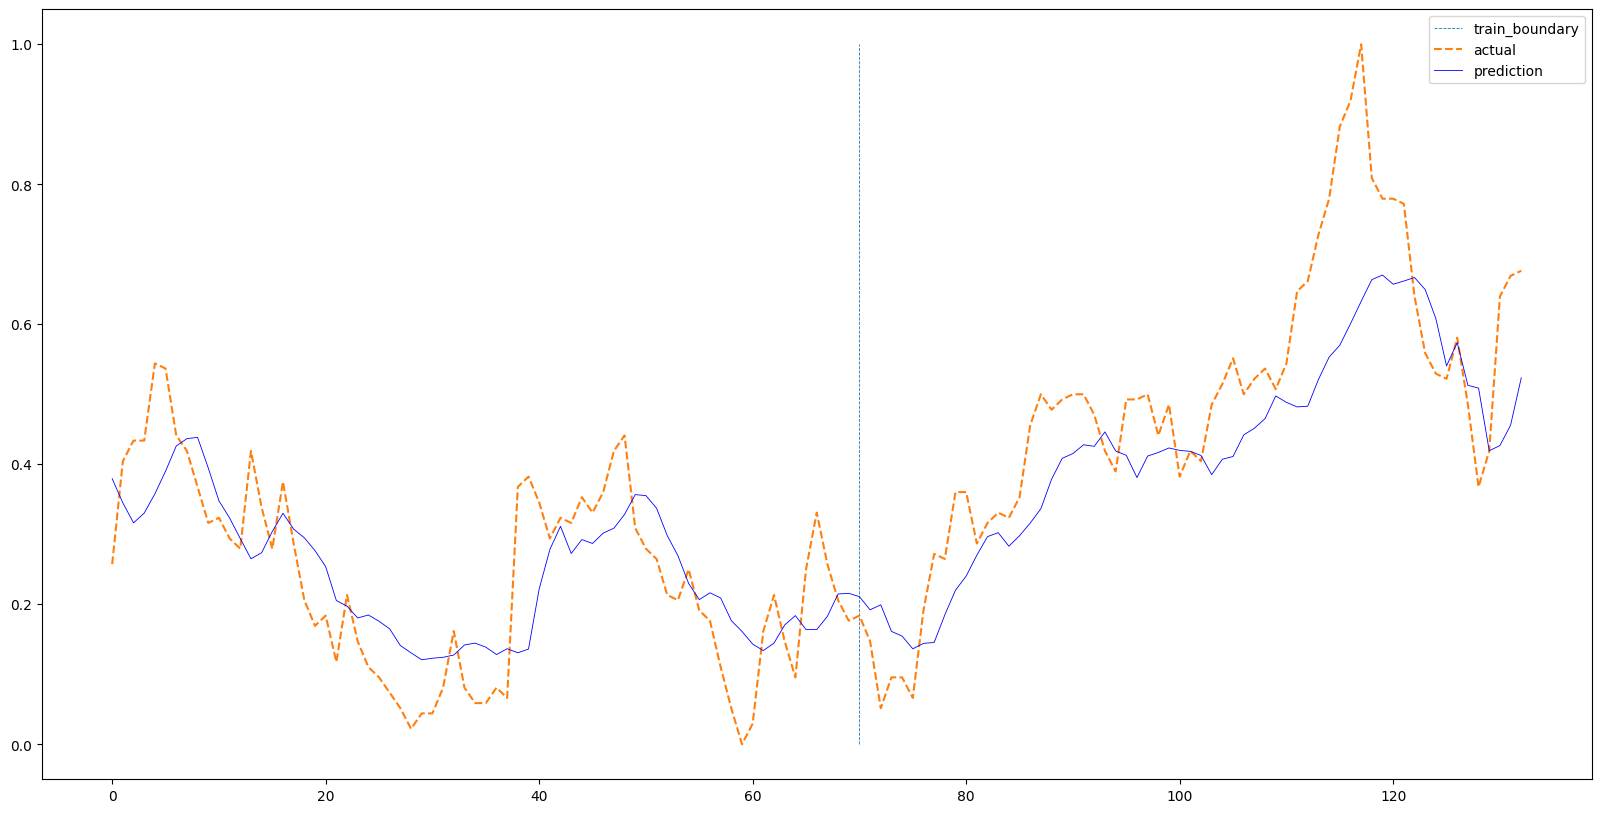

In [24]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# 파란색이 실제값, 주황색이 예측값

# LSTM

## 모델 구축

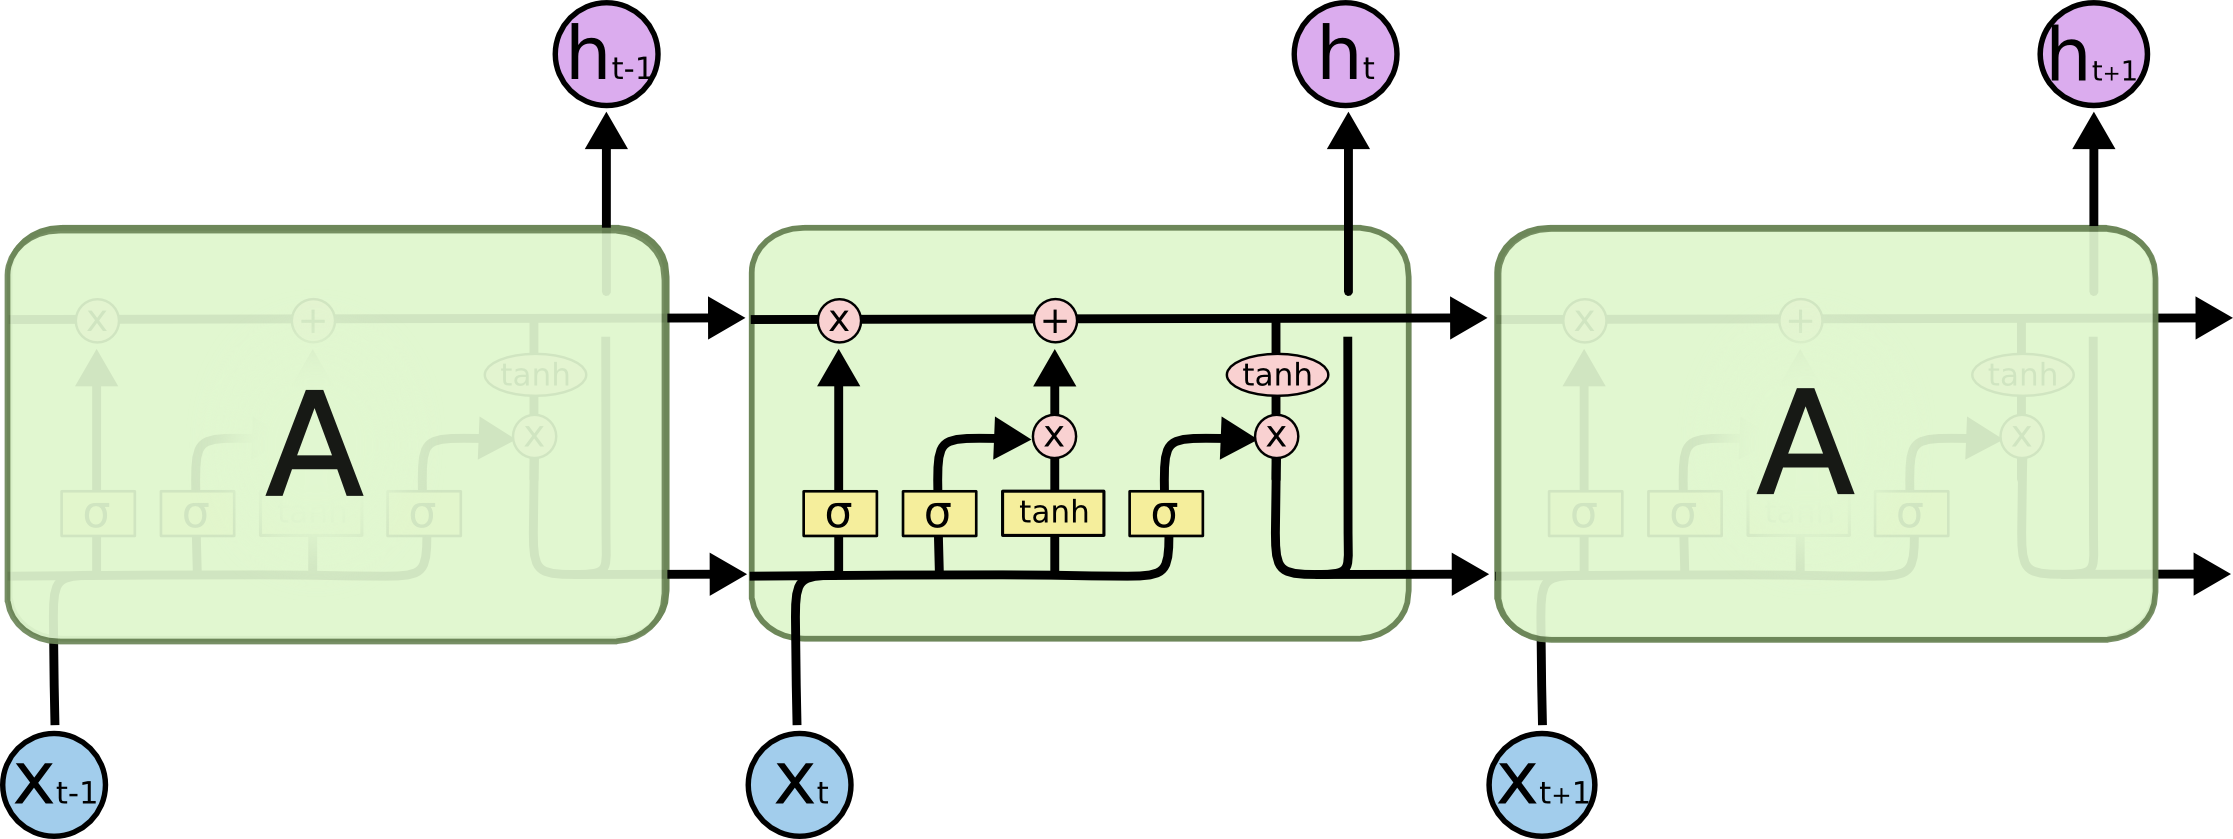

**LSTM(Long Short Term Memory)**
- RNN의 **장기 의존성 문제**를 해결하기 위해서 나온 모델. 앞서 RNN은 시퀀스 길이가 길면 먼 과거의 정보가 현재까지 도달하지 않는 기울기 소실 문제가 발생. 좀 더 거시적으로 과거 데이터를 고려하여 미래 데이터를 예측하기 위해 나옴.

1. cell state
: 정보가 바뀌지 않고 그대로 흐르게 하는 부분. Gate라고 불리는 구조에 의해 정보가 추가되거나 제거되고, Gate는 학습을 통해 어떤 정보를 유지하고 버릴지 학습함.
2. Forget Gate(망각 게이트)
: 과거의 정보를 버릴지 말지 결정하는 과정. sigmoid layer에 의해 결정됨. t-1 시점의 은닉 상태와 t 시점의 입력값을 받아 0~1 사이의 값을 t-1 시점의 셀 값에 보내줌.
  - 1이면 모든 정보를 보존해라.
  - 0이면 모두 갖다 버려라.
3. Input Gate(입력 게이트)
: 현재 정보를 기억하기 위한 게이트. t 시점의 Cell state 값에 얼마나 더할지 말지를 결정하는 역할.
4. Update
: 과거 Cell state를 새로운 state로 업데이트 하는 과정. forget gate를 통해 얼마나 버릴지, input gate에서 얼마나 더할지 정한 후 cell state로 업데이트 해줌.
5. Output Gate(출력 게이트)
: 어떤 출력값을 출력할지 결정하는 과정. 최종적으로 얻어진 Cell State 값을 얼마나 빼낼지 결정하는 역할.

In [25]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [26]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #은닉 상태
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #셀 상태(cell state)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [27]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [28]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [29]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.0685
[epoch: 10] loss: 0.0113
[epoch: 20] loss: 0.0101
[epoch: 30] loss: 0.0090
[epoch: 40] loss: 0.0081


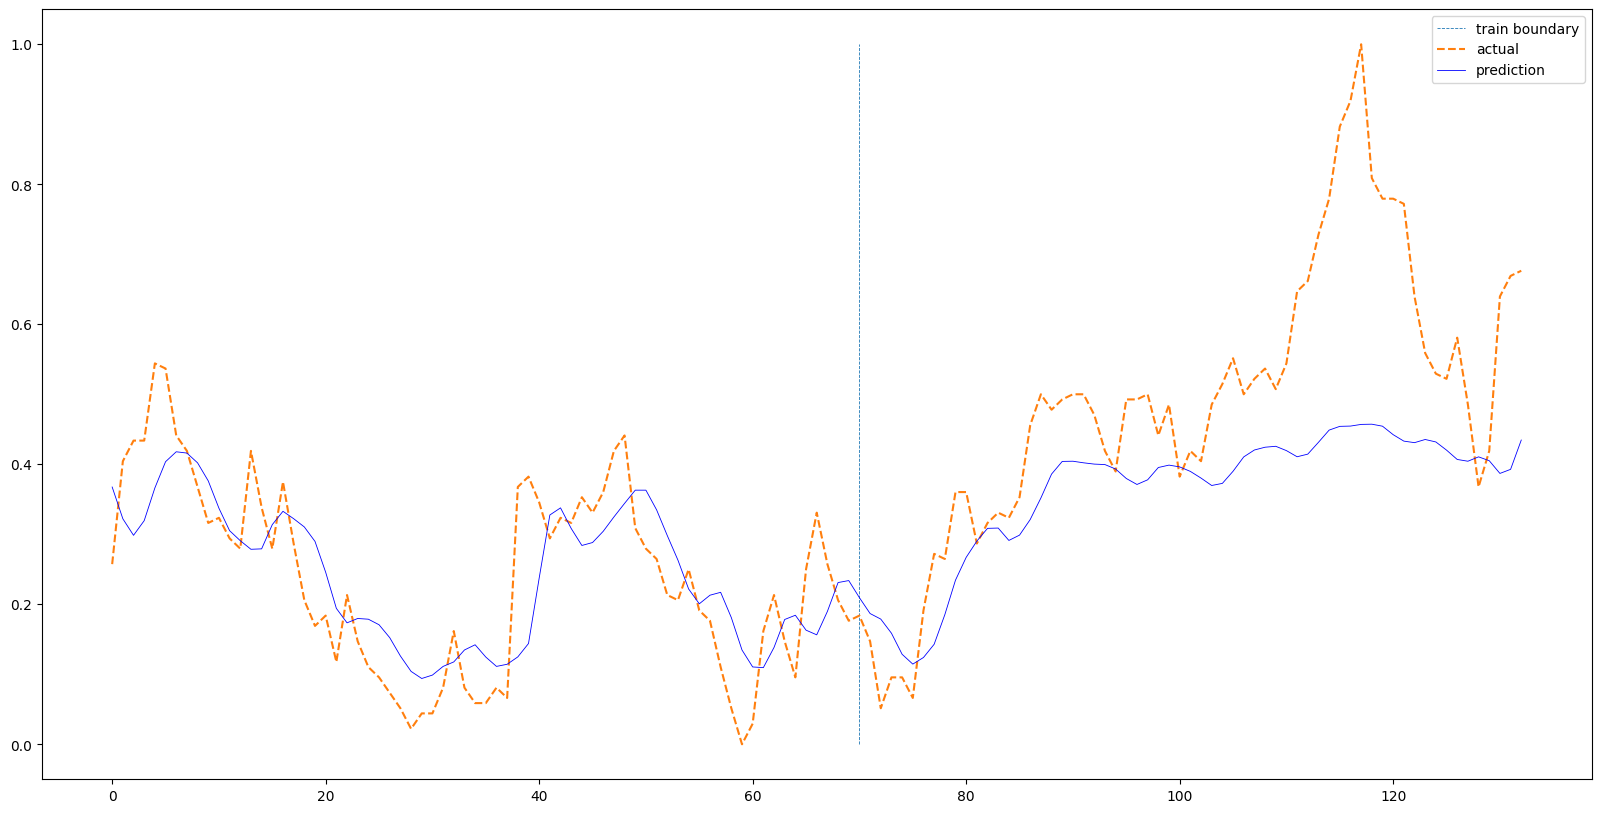

In [30]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()